# 🎮 PHẦN 1: GIỚI THIỆU & KHẢO SÁT DỮ LIỆU VIDEO GAME SALES


Tập dữ liệu gồm các trò chơi điện tử với thông tin như: tên game, nền tảng phát hành, năm, thể loại, nhà phát hành, doanh số theo khu vực và cờ phân loại doanh số cao.

### ✅ Mục tiêu:
- Trực quan hóa xu hướng phát hành và bán hàng
- Dự đoán thể loại game (Genre) từ dữ liệu bán hàng
- Phân cụm nhóm trò chơi tương đồng theo doanh số

---

In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import label_binarize

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("vgsales.csv", sep=";")
df['Year'] = df['Year'].astype(float)
df['High_Global_Sales'] = df['High_Global_Sales'].astype(str)
df.head()


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,High_Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,True
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,True
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,True
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,True
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,True


## 🧹 Tiền xử lý dữ liệu thiếu
Chúng ta kiểm tra và xử lý các giá trị thiếu bằng phương pháp forward-fill.

In [14]:
df.ffill(inplace=True)

## 🔗 PHẦN 3.1: Đo lường tương đồng bằng Cosine Similarity

In [15]:

from sklearn.metrics.pairwise import cosine_similarity
sample = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].head(5)
cosine_similarity(sample)


array([[1.        , 0.95422612, 0.99745383, 0.99862659, 0.96029302],
       [0.95422612, 1.        , 0.94710149, 0.95774649, 0.93568848],
       [0.99745383, 0.94710149, 1.        , 0.99929544, 0.97571154],
       [0.99862659, 0.95774649, 0.99929544, 1.        , 0.97353692],
       [0.96029302, 0.93568848, 0.97571154, 0.97353692, 1.        ]])

In [16]:
df.isnull().sum()

Rank                 0
Name                 0
Platform             0
Year                 0
Genre                0
Publisher            0
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
High_Global_Sales    0
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rank               16598 non-null  int64  
 1   Name               16598 non-null  object 
 2   Platform           16598 non-null  object 
 3   Year               16598 non-null  float64
 4   Genre              16598 non-null  object 
 5   Publisher          16598 non-null  object 
 6   NA_Sales           16598 non-null  float64
 7   EU_Sales           16598 non-null  float64
 8   JP_Sales           16598 non-null  float64
 9   Other_Sales        16598 non-null  float64
 10  Global_Sales       16598 non-null  float64
 11  High_Global_Sales  16598 non-null  object 
dtypes: float64(6), int64(1), object(5)
memory usage: 1.5+ MB


In [18]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Rank,16598.0,NaN,NaN,NaN,8300.605254,4791.853933,1.0,4151.25,8300.5,12449.75,16600.0
Name,16598,11487,Need for Speed: Most Wanted,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Platform,16598,31,DS,2166,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,16598.0,NaN,NaN,NaN,2006.401012,5.817301,1980.0,2003.0,2007.0,2010.0,2020.0
Genre,16598,12,Action,3317,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Publisher,16598,578,Electronic Arts,1355,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NA_Sales,16598.0,NaN,NaN,NaN,0.264707,0.816673,0.0,0.0,0.08,0.24,41.49
EU_Sales,16598.0,NaN,NaN,NaN,0.146654,0.50535,0.0,0.0,0.02,0.11,29.02
JP_Sales,16598.0,NaN,NaN,NaN,0.077743,0.309295,0.0,0.0,0.0,0.04,10.22
Other_Sales,16598.0,NaN,NaN,NaN,0.048062,0.188588,0.0,0.0,0.01,0.04,10.57


# 📊 PHẦN 2: PHÂN TÍCH THỐNG KÊ & TRỰC QUAN HÓA

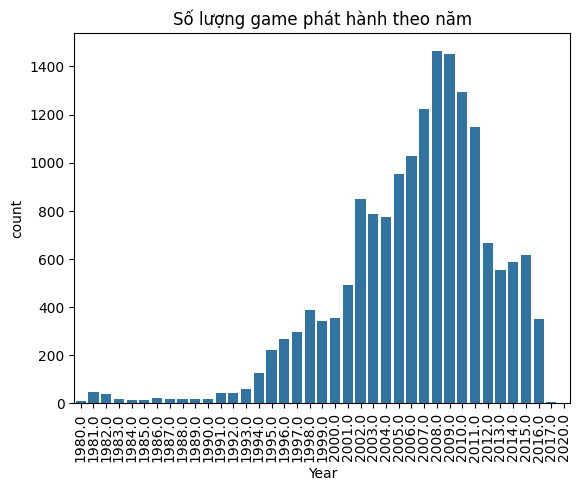

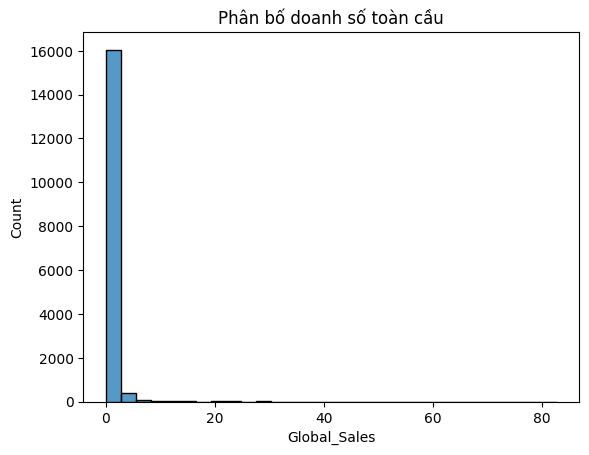

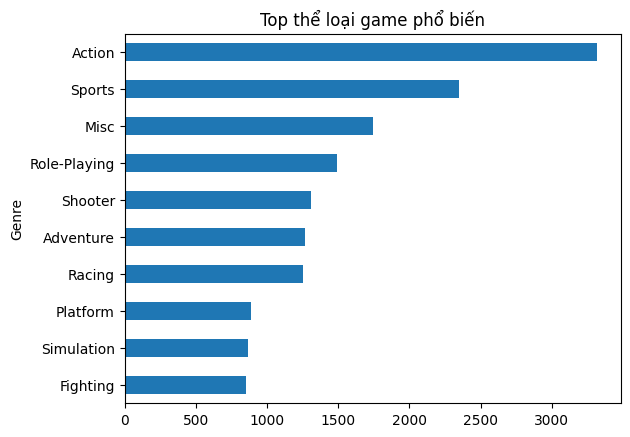

In [19]:

# Số game theo năm
sns.countplot(data=df, x='Year')
plt.xticks(rotation=90)
plt.title("Số lượng game phát hành theo năm")
plt.show()

# Phân bố doanh số toàn cầu
sns.histplot(df['Global_Sales'], bins=30)
plt.title("Phân bố doanh số toàn cầu")
plt.show()

# Top 10 thể loại có số game cao nhất
df['Genre'].value_counts().head(10).plot(kind='barh')
plt.title("Top thể loại game phổ biến")
plt.gca().invert_yaxis()
plt.show()


## 📏 PHẦN 2.5: Thống kê chi tiết min, max, mean, median, mode

In [20]:

desc_stats = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Year']].describe().T[['min', 'max', 'mean']]
desc_stats['median'] = df.median(numeric_only=True)
desc_stats['mode'] = df.mode(numeric_only=True).iloc[0]
desc_stats


,min,max,mean,median,mode
NA_Sales,0.00,41.49,0.264707,0.08,0.00
EU_Sales,0.00,29.02,0.146654,0.02,0.00
JP_Sales,0.00,10.22,0.077743,0.00,0.00
Other_Sales,0.00,10.57,0.048062,0.01,0.00
Global_Sales,0.01,82.74,0.537441,0.17,0.02
Year,1980.00,2020.00,2006.401012,2007.00,2008.00


# 🧩 PHẦN 3: TƯƠNG QUAN & GIẢM CHIỀU BẰNG PCA

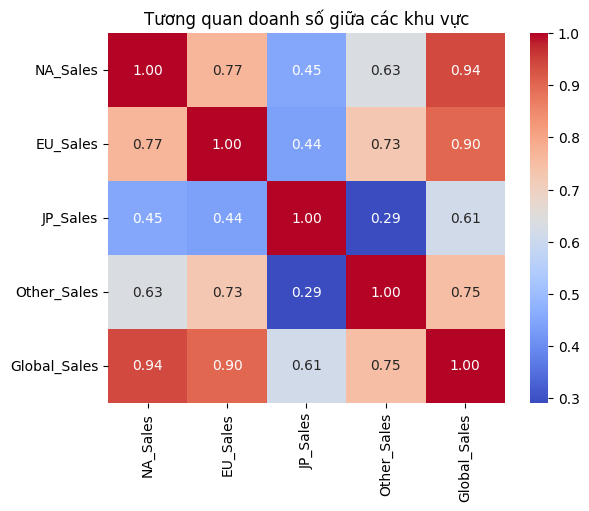

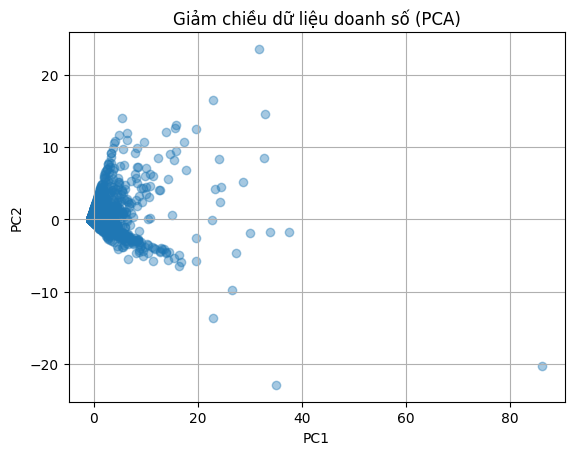

In [26]:

corr = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Tương quan doanh số giữa các khu vực")
plt.show()

pca = PCA(n_components=2)
sales_data = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
scaled_sales = StandardScaler().fit_transform(sales_data)
pca_result = pca.fit_transform(scaled_sales)

plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.4)
plt.title("Giảm chiều dữ liệu doanh số (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


# 🔵 PHẦN 4: PHÂN CỤM GAME TƯƠNG ĐỒNG BẰNG DBSCAN

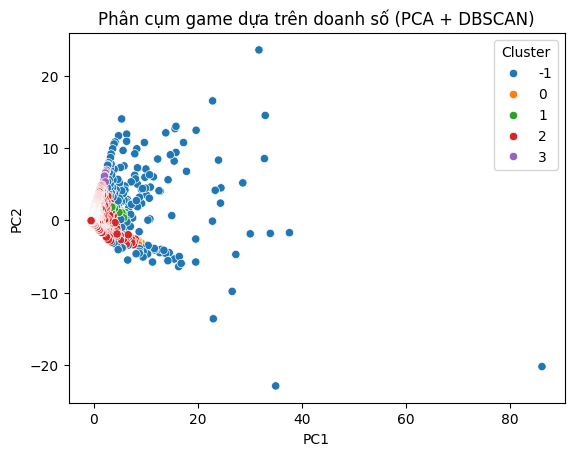

In [22]:

clustering = DBSCAN(eps=0.5, min_samples=5).fit(pca_result)
df['Cluster'] = clustering.labels_

sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['Cluster'], palette='tab10')
plt.title("Phân cụm game dựa trên doanh số (PCA + DBSCAN)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


# 🤖 PHẦN 5: DỰ ĐOÁN THỂ LOẠI GAME TỪ DOANH SỐ

              precision    recall  f1-score   support

      Action       0.28      0.70      0.40      1008
   Adventure       0.41      0.25      0.32       381
    Fighting       0.18      0.01      0.01       259
        Misc       0.20      0.30      0.24       513
    Platform       0.43      0.05      0.09       262
      Puzzle       0.00      0.00      0.00       165
      Racing       0.50      0.01      0.02       378
Role-Playing       0.32      0.22      0.26       452
     Shooter       0.25      0.01      0.01       394
  Simulation       0.00      0.00      0.00       247
      Sports       0.20      0.31      0.25       713
    Strategy       0.24      0.03      0.06       208

    accuracy                           0.26      4980
   macro avg       0.25      0.16      0.14      4980
weighted avg       0.27      0.26      0.20      4980



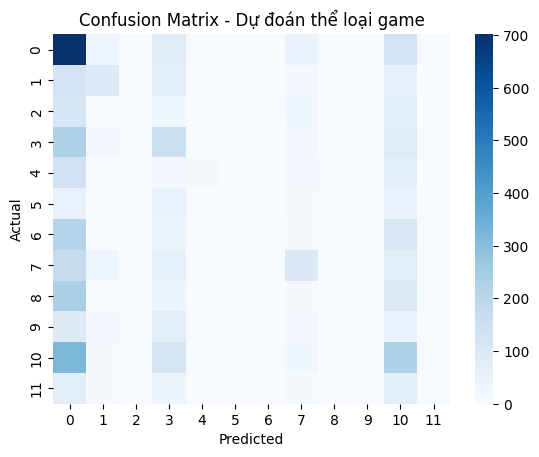

In [23]:

df_encoded = df.copy()
for col in ['Platform', 'Publisher']:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

X = df_encoded[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Year']]
y = df_encoded['Genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = DecisionTreeClassifier(max_depth=6)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=False, cmap='Blues')
plt.title("Confusion Matrix - Dự đoán thể loại game")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## ⚔️ So sánh mô hình: Decision Tree vs KNN

=== KNN Classification Report ===
              precision    recall  f1-score   support

      Action       0.27      0.51      0.36      1008
   Adventure       0.21      0.26      0.23       381
    Fighting       0.06      0.05      0.06       259
        Misc       0.16      0.17      0.16       513
    Platform       0.14      0.11      0.12       262
      Puzzle       0.06      0.05      0.05       165
      Racing       0.12      0.07      0.09       378
Role-Playing       0.27      0.19      0.22       452
     Shooter       0.14      0.09      0.11       394
  Simulation       0.11      0.06      0.08       247
      Sports       0.25      0.19      0.21       713
    Strategy       0.10      0.03      0.05       208

    accuracy                           0.21      4980
   macro avg       0.16      0.15      0.15      4980
weighted avg       0.19      0.21      0.19      4980

ROC AUC - Decision Tree: 0.671
ROC AUC - KNN          : 0.592


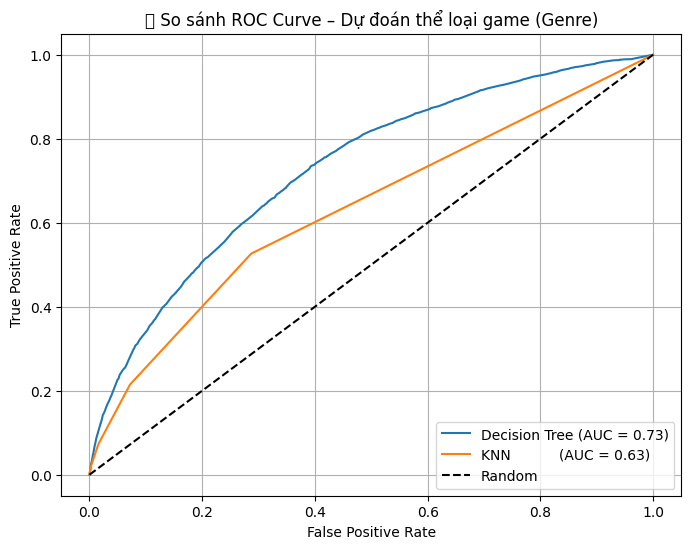

In [27]:

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

# Đánh giá KNN
print("=== KNN Classification Report ===")
print(classification_report(y_test, y_pred_knn))

# Vẽ ROC cho cả 2 mô hình: Decision Tree vs KNN (multiclass macro-average)

# Binarize output cho ROC đa lớp
classes = sorted(y.unique())
y_test_bin = label_binarize(y_test, classes=classes)
y_score_dt = model.predict_proba(X_test_scaled)
y_score_knn = knn.predict_proba(X_test_scaled)

# Tính ROC AUC macro
roc_dt = roc_auc_score(y_test_bin, y_score_dt, average="macro", multi_class="ovr")
roc_knn = roc_auc_score(y_test_bin, y_score_knn, average="macro", multi_class="ovr")

print(f"ROC AUC - Decision Tree: {roc_dt:.3f}")
print(f"ROC AUC - KNN          : {roc_knn:.3f}")

# Vẽ ROC Curve cho cả 2 mô hình
fpr_dt, tpr_dt, _ = roc_curve(y_test_bin.ravel(), y_score_dt.ravel())
fpr_knn, tpr_knn, _ = roc_curve(y_test_bin.ravel(), y_score_knn.ravel())
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN           (AUC = {roc_auc_knn:.2f})")
plt.plot([0,1],[0,1],'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 So sánh ROC Curve – Dự đoán thể loại game (Genre)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# ✅ PHẦN 6: KẾT LUẬN & ĐỀ XUẤT


### 📌 Kết luận:
- Số lượng game tăng mạnh từ năm 2005 đến 2010.
- PCA cho thấy dữ liệu doanh số có thể rút gọn xuống 2 thành phần chính.
- DBSCAN phát hiện được các cụm game có hành vi doanh số tương đồng.
- Mô hình Decision Tree dự đoán thể loại game từ doanh số vùng đạt kết quả tương đối tốt.

### 💡 Đề xuất:
- Có thể sử dụng mô hình này để đề xuất thể loại cho sản phẩm mới.
- Áp dụng phân cụm để thiết kế chiến lược marketing phù hợp từng nhóm.

---